<a href="https://colab.research.google.com/github/JoanesMiranda/Machine-learning/blob/master/Aplicando_Redes_Neurais_Convolucionais_a_base_de_dados_Twitter_em_portugues.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Unifacisa Centro Universitario

- **Curso:** Pós-Graduação em Ciência de Dados.
- **Disciplina:**  Processamento de Linguagem Natural.
- **Professor:** Jones Granatyr.
- **Aluno:** Joanes Miranda de Souto.


# Etapa 1: Importação das bibliotecas

In [ ]:
# Teoria CNN para textos
# Classificação de sentimentos com CNN
# Teoria RNN
# Classificação de sentimentos com RNN
# Geração de novos textos com RNN

# Transformer
# Tradutor de idiomas: EN -> PT
# BERT
# Q&A
# Orange

# Base de dados
# https://drive.google.com/file/d/1dEhKrvPTli4NK7Aaa2lACx2NvjVwWf9d/view?usp=sharing

import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup
from google.colab import drive
import zipfile
import seaborn as sns
import spacy as sp
import string
import random
import spacy
import matplotlib.pyplot as plt

In [ ]:
!python3 -m spacy download pt

✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/pt_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/pt
You can now load the model via spacy.load('pt')


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.4.1'

In [ ]:
from tensorflow.keras import layers
import tensorflow_datasets as tfds

# Etapa 2: Pré-processamento dos dados

## Carregamento dos arquivos

In [ ]:
train_data = pd.read_csv('/content/Train50.csv', delimiter=";")

In [ ]:
train_data.shape

(50000, 5)

In [ ]:
train_data.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1050785521201541121,@Laranjito76 A pessoa certa para isso seria o ...,Fri Oct 12 16:29:25 +0000 2018,1,:)
1,1050785431955140608,"@behin_d_curtain Para mim, é precisamente o co...",Fri Oct 12 16:29:04 +0000 2018,1,:)
2,1050785401248645120,Vou fazer um video hoje... estou pensando em f...,Fri Oct 12 16:28:56 +0000 2018,1,:)
3,1050785370982547461,"aaaaaaaa amei tanto essas polaroids, nem sei e...",Fri Oct 12 16:28:49 +0000 2018,1,:)
4,1050785368902131713,Valoriza o coração do menininho que vc tem. El...,Fri Oct 12 16:28:49 +0000 2018,1,:)


In [ ]:
train_data.tail()

,id,tweet_text,tweet_date,sentiment,query_used
49995,1046762827053232128,:( é tão lindo que dói https://t.co/GqnpgyWWxB,Mon Oct 01 14:04:40 +0000 2018,0,:(
49996,1046762813362966529,"@veraluciarj Pois é.. tenho problema c/ ""coisa...",Mon Oct 01 14:04:37 +0000 2018,0,:(
49997,1046762806392082432,eu te amo tanto minja vidinha meu bem mais pre...,Mon Oct 01 14:04:35 +0000 2018,0,:(
49998,1046762752071618560,@itsLary @jessboluda Pfvor :(,Mon Oct 01 14:04:22 +0000 2018,0,:(
49999,1046762735340584962,@Renk_lol Passa ano Entra ano Eu nao desisto d...,Mon Oct 01 14:04:18 +0000 2018,0,:(


In [ ]:
train_data.sentiment.unique()

array([1, 0])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


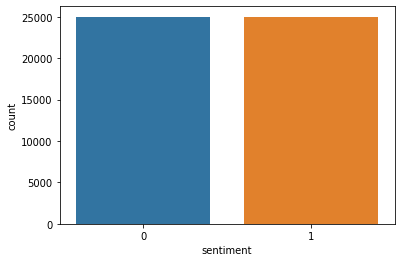

In [ ]:
sns.countplot(train_data.sentiment);

In [ ]:
test_data = pd.read_csv("/content/Test.csv",delimiter=";")

In [ ]:
test_data.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1029536486021099522,@Gazo1a Nossa! Muito obrigada :),Wed Aug 15 01:13:20 +0000 2018,1,:)
1,1029536496368406528,@BerzGamer vai pa puta que te pariu :),Wed Aug 15 01:13:23 +0000 2018,1,:)
2,1029536531655131137,QUER MAIS DESCONTOS? (14/08) ⭐⭐⭐⭐⭐ 🌐 Confira n...,Wed Aug 15 01:13:31 +0000 2018,1,:)
3,1029536560117678081,"EU VOU PEGAR VCS, ME AJUDEM GALERA, PELO AMOR ...",Wed Aug 15 01:13:38 +0000 2018,1,:)
4,1029536605852377088,Estávamos em casa do Zé e eu estava a morrer d...,Wed Aug 15 01:13:49 +0000 2018,1,:)


In [ ]:
test_data.shape

(5000, 5)

In [ ]:
test_data.sentiment.unique()

array([1, 0])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


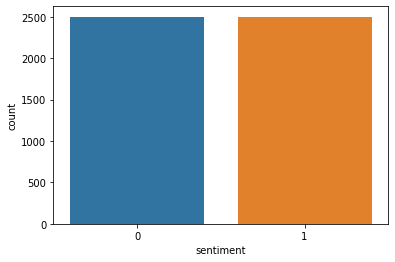

In [ ]:
sns.countplot(test_data.sentiment);

## Pré-processamento

### Limpeza

In [ ]:
data = train_data

In [ ]:
data.drop(['id', 'tweet_date', 'query_used'], axis = 1, inplace=True)

In [ ]:
data.head()

,tweet_text,sentiment
0,@Laranjito76 A pessoa certa para isso seria o ...,1
1,"@behin_d_curtain Para mim, é precisamente o co...",1
2,Vou fazer um video hoje... estou pensando em f...,1
3,"aaaaaaaa amei tanto essas polaroids, nem sei e...",1
4,Valoriza o coração do menininho que vc tem. El...,1


In [ ]:
X = data.iloc[:, 0].values

In [ ]:
X

array(['@Laranjito76 A pessoa certa para isso seria o vale e azevedo :)',
       '@behin_d_curtain Para mim, é precisamente o contrário :) Vem a chuva e vem a boa disposição :)',
       'Vou fazer um video hoje... estou pensando em falar um pouco sobre o novo meta do CSGO e sobre a pagina https://t.co/5RjhKnj0oh Alguem tem uma sugestao? Queria falar sobre algo do cenario nacional :D',
       ...,
       'eu te amo tanto minja vidinha meu bem mais precioso me desculpa ser uma péssima utted mas eu te amo mais que tudo nem palavras é capaz de explicar o tamanho do amor que sinto por ti :(((( https://t.co/4ND7F203et',
       '@itsLary @jessboluda Pfvor :(',
       '@Renk_lol Passa ano Entra ano Eu nao desisto do NA :('],
      dtype=object)

In [ ]:
X.shape

(50000,)

In [ ]:
type(X)

numpy.ndarray

In [ ]:
y = data.iloc[:, 1].values
y

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
from sklearn.model_selection import train_test_split
X, _, y, _ = train_test_split(X, y, test_size = 0.85, stratify = y)

In [ ]:
X.shape

(7500,)

In [ ]:
y.shape

(7500,)

In [ ]:
unique, counts = np.unique(y, return_counts=True)
unique, counts

(array([0, 1]), array([3750, 3750]))

In [ ]:
def clean_tweets(tweet):
  tweet = BeautifulSoup(tweet, 'lxml').get_text()
  tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)
  tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)
  tweet = re.sub(r"[^a-zA-Z.!?]", ' ', tweet)
  tweet = re.sub(r" +", ' ', tweet)
  return tweet

In [ ]:
text = '@behin_d_curtain :D Para :( mim, http://www.iaexpert.com.br é precisamente o contrário :) Vem a chuva e vem a boa disposição :)'

In [ ]:
text = clean_tweets(text)
text

' d curtain D Para mim precisamente o contr rio Vem a chuva e vem a boa disposi o '

In [ ]:
pln = spacy.load('pt')
pln

In [ ]:
stop_words = sp.lang.pt.STOP_WORDS

In [ ]:
print(stop_words)

{'coisa', 'povo', 'antes', 'sim', 'pela', 'tiveste', 'estes', 'cima', 'inicio', 'momento', 'questão', 'onze', 'ainda', 'oito', 'mês', 'meus', 'à', 'os', 'faço', 'saber', 'tais', 'eles', 'depois', 'foi', 'pouco', 'quanto', 'para', 'esse', 'vossos', 'pegar', 'esteve', 'estás', 'fazem', 'vens', 'quarto', 'direita', 'sob', 'ela', 'fim', 'inclusive', 'tempo', 'de', 'dezasseis', 'até', 'novos', 'isso', 'que', 'neste', 'vossa', 'todo', 'seus', 'somente', 'temos', 'daquela', 'tentar', 'devem', 'contra', 'onde', 'podem', 'enquanto', 'diante', 'era', 'quinze', 'estivestes', 'sempre', 'três', 'apoio', 'está', 'vezes', 'catorze', 'dizem', 'vinte', 'nessa', 'faz', 'têm', 'vários', 'oitavo', 'me', 'quê', 'oitava', 'querem', 'aqui', 'treze', 'tivestes', 'tuas', 'pelo', 'aquelas', 'sois', 'logo', 'ver', 'contudo', 'vêm', 'no', 'ontem', 'qual', 'dez', 'quatro', 'ademais', 'algumas', 'diz', 'sobre', 'ao', 'vocês', 'falta', 'sei', 'nenhuma', 'qualquer', 'desta', 'grupo', 'tão', 'sétima', 'grandes', 'nós'

In [ ]:
len(stop_words)

413

In [ ]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
def clean_tweets2(tweet):
  tweet = tweet.lower()
  document = pln(tweet)

  words = []
  for token in document:
    words.append(token.text)

  words = [word for word in words if word not in stop_words and word not in string.punctuation]
  words = ' '.join([str(element) for element in words])

  return words

In [ ]:
text2 = clean_tweets2(text)
text2

'  d curtain d mim precisamente o contr rio a chuva e a disposi o'

In [ ]:
data_clean = [clean_tweets2(clean_tweets(tweet)) for tweet in X]

In [ ]:
for _ in range(10):
  print(data_clean[random.randint(0, len(data_clean) - 1)])

gente o mata n o existe paridade armas n turno lutar espalha manu d vila disse cristo deveria abortado inquieta
  biiancat s fds
postei coisas estavam timas indo agr coisas come aram a desabar q puts explica o
o almo o caril i m happy
t t o tisti algu m d a temporada dirk gently s holistic detective agency
  mimimi ... papo dio mimim puro paz n dio
  nah t suave tks
  felicidades
  achei gatinho
  a robs espero esteja


In [ ]:
data_labels = y

In [ ]:
data_labels[data_labels == 4] = 1

In [ ]:
data_labels

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
np.unique(data_labels)

array([0, 1])

### Tokenização

In [ ]:
2**16

65536

In [ ]:
import math
math.pow(2, 16)

65536.0

In [ ]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(data_clean, target_vocab_size=2**16)

In [ ]:
tokenizer.vocab_size

14185

In [ ]:
print(tokenizer.subwords)

['o_', '  ', 'a_', 'e_', 'n_', 's_', 'pra_', 't_', 'd_', 'm_', 'q_', 'voc_', 'vou_', 'to_', 'j_', 'dia_', 'queria_', 'vc_', ' ... ', 'pq_', 'p_', 'gente_', 'est_', 'ai_', 'nao_', 'v_', 'hoje_', 'c_', 'triste_', 'at_', 'ta_', 'tamb_', 'acho_', 'f_', 'amo_', 'ficar_', 'rio_', 'pessoas_', 'b_', 'pro_', 'l_', 'es_', 'melhor_', 'ent_', ' ...', 'tava_', 'mt_', 'cara_', 'vel_', 'algu_', 'vida_', 'mim_', 'feliz_', 'casa_', 'fico_', '. ', 'pr_', 'falar_', 'pessoa_', 'espero_', 'dormir_', 'dias_', 'consigo_', 'tinha_', 'h_', 'come_', 'vi_', 'vamos_', 'triste', 'pt_', 'amor_', 'sinto_', 'coisas_', 'semana_', 'ja_', 'ah_', 'ncia_', 'fica_', 'cora_', 'anos_', 'votar_', 'mundo_', 'fa_', 'ciro_', 'ningu_', 'fiquei_', 'eh_', 'dia', 'noite_', 'medo_', 'ia_', 'dio_', 'bar_', 'tbm_', 'olha_', 'mano_', 'infelizmente_', 'elei_', 'ria_', 'pa_', 'saudade_', 'verdade_', 'vcs_', 'parab_', 'oi_', 'linda_', 'bolsonaro_', 'deus_', 'amiga_', 'amanh_', 'vontade_', 'pior_', 'fiz_', 'so_', 'realmente_', 'achei_', 'ci

In [ ]:
ids = tokenizer.encode('i am happy')
ids

[170, 207, 9759]

In [ ]:
text = tokenizer.decode(ids)
text

'i am happy'

In [ ]:
data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

In [ ]:
for _ in range(10):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[301, 7, 2820, 1606, 4, 454, 918, 242, 66, 3, 14043]
[2, 404, 684, 115, 13779, 1, 203, 2807, 6, 23, 1, 11376, 1416, 4, 214, 2188]
[2, 270, 2553, 1, 17, 1, 12, 844, 1372, 49, 3517]
[2, 980, 5473, 14029]
[53, 1376, 13008, 11750]
[2, 76, 731, 39, 194, 1, 5, 1, 5460, 1, 9, 719, 360, 54, 9, 4, 920, 7, 5, 1, 5267]
[14, 1461, 50, 10, 961, 739]
[12436, 1139, 19, 89, 8771]
[2, 16, 13422]
[103, 11, 5487, 324, 20, 14, 2910, 7, 627]


### Padding

In [ ]:
max_len = max([len(sentence) for sentence in data_inputs])
max_len

45

In [ ]:
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value = 0,
                                                            padding = 'post',
                                                            maxlen=max_len)

In [ ]:
for _ in range(10):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[13961     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0]
[ 731    5 1486 1651    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]
[   2   14    6  337    1  461 1784   66  873    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]
[   22    71   108     5  2924    26   143  1400   156  8637  1460     7
  1434     1 11507    11     5     7  1191    11  8233  8932     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0    

### Divisão da base de dados em treinamento e teste



In [ ]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(data_inputs,
                                                                        data_labels,
                                                                        test_size=0.3,
                                                                        stratify = data_labels)

In [ ]:
train_inputs[0]

array([    2, 13193,  8322,     4,    34,    20,   152,  1002,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0],
      dtype=int32)

In [ ]:
train_inputs.shape

(5250, 45)

In [ ]:
train_labels.shape

(5250,)

In [ ]:
test_inputs.shape

(2250, 45)

In [ ]:
test_labels.shape

(2250,)

# Etapa 3: Construção do modelo

In [ ]:
class DCNN(tf.keras.Model):

  def __init__(self,
               vocab_size,
               emb_dim=128,
               nb_filters=50,
               ffn_units=512,
               nb_classes=2,
               dropout_rate=0.1,
               training=True,
               name="dcnn"):
    super(DCNN, self).__init__(name=name)

    self.embedding = layers.Embedding(vocab_size, emb_dim)

    self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=2, padding='same', activation='relu')

    self.trigram = layers.Conv1D(filters=nb_filters, kernel_size=3, padding='same', activation='relu')

    self.fourgram = layers.Conv1D(filters=nb_filters, kernel_size=4, padding='same', activation='relu')

    self.pool = layers.GlobalMaxPool1D()

    self.dense_1 = layers.Dense(units = ffn_units, activation = 'relu')
    self.dropout = layers.Dropout(rate = dropout_rate)
    if nb_classes == 2:
      self.last_dense = layers.Dense(units = 1, activation = 'sigmoid')
    else:
      self.last_dense = layers.Dense(units = nb_classes, activation = 'softmax')

  def call(self, inputs, training):
    x = self.embedding(inputs)
    x_1 = self.bigram(x)
    x_1 = self.pool(x_1)
    x_2 = self.trigram(x)
    x_2 = self.pool(x_2)
    x_3 = self.fourgram(x)
    x_3 = self.pool(x_3)

    merged = tf.concat([x_1, x_2, x_3], axis = -1) # (batch_size, 3 * nb_filters)
    merged = self.dense_1(merged)
    merged = self.dropout(merged, training)
    output = self.last_dense(merged)

    return output

# Etapa 4: Treinamento

## Configuração dos parâmetros

In [ ]:
vocab_size = tokenizer.vocab_size
vocab_size

14185

In [ ]:
emb_dim = 200
nb_filters = 100
ffn_units = 256
batch_size = 64
nb_classes = len(set(train_labels))
nb_classes

2

In [ ]:
dropout_rate = 0.2
nb_epochs = 20

## Treinamento

In [ ]:
Dcnn = DCNN(vocab_size=vocab_size, emb_dim=emb_dim, nb_filters=nb_filters,
            ffn_units=ffn_units, nb_classes=nb_classes, dropout_rate=dropout_rate)

In [ ]:
if nb_classes == 2:
  Dcnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
else:
  Dcnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
checkpoint_path = "./"
ckpt = tf.train.Checkpoint(Dcnn=Dcnn)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored')

In [ ]:
history = Dcnn.fit(train_inputs, train_labels,
                   batch_size = batch_size,
                   epochs = nb_epochs,
                   verbose = 1,
                   validation_split = 0.10)
ckpt_manager.save()

Epoch 1/20
74/74 [==============================] - 4s 37ms/step - loss: 0.6754 - accuracy: 0.5617 - val_loss: 0.5335 - val_accuracy: 0.7124
Epoch 2/20
74/74 [==============================] - 2s 29ms/step - loss: 0.3610 - accuracy: 0.8564 - val_loss: 0.6019 - val_accuracy: 0.7124
Epoch 3/20
74/74 [==============================] - 2s 29ms/step - loss: 0.1095 - accuracy: 0.9635 - val_loss: 0.7862 - val_accuracy: 0.7200
Epoch 4/20
74/74 [==============================] - 2s 29ms/step - loss: 0.0485 - accuracy: 0.9804 - val_loss: 0.9522 - val_accuracy: 0.7105
Epoch 5/20
74/74 [==============================] - 2s 28ms/step - loss: 0.0241 - accuracy: 0.9895 - val_loss: 1.0364 - val_accuracy: 0.6933
Epoch 6/20
74/74 [==============================] - 2s 28ms/step - loss: 0.0178 - accuracy: 0.9931 - val_loss: 1.1302 - val_accuracy: 0.6914
Epoch 7/20
74/74 [==============================] - 2s 28ms/step - loss: 0.0185 - accuracy: 0.9905 - val_loss: 1.2062 - val_accuracy: 0.6990
Epoch 8/20
74

'./ckpt-1'

# Etapa 5: Avaliação do modelo

## Avaliação

In [ ]:
results = Dcnn.evaluate(test_inputs, test_labels, batch_size=batch_size)
print(results)

36/36 [==============================] - 0s 7ms/step - loss: 1.6267 - accuracy: 0.6884
[1.6266560554504395, 0.6884444355964661]


In [ ]:
y_pred_test = Dcnn.predict(test_inputs)

In [ ]:
y_pred_test

array([[4.6852283e-02],
       [4.2771748e-03],
       [3.7634433e-03],
       ...,
       [5.4152474e-06],
       [6.1805570e-04],
       [8.3414829e-01]], dtype=float32)

In [ ]:
y_pred_test = (y_pred_test > 0.5)

In [ ]:
y_pred_test

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [ True]])

In [ ]:
test_labels

array([0, 0, 1, ..., 0, 0, 1])

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, y_pred_test)
cm

array([[795, 330],
       [371, 754]])

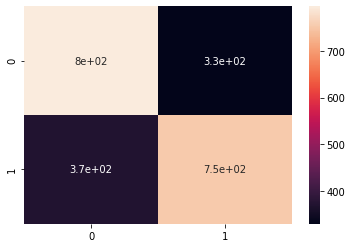

In [ ]:
sns.heatmap(cm, annot=True)

In [ ]:
history.history.keys()sentiment

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

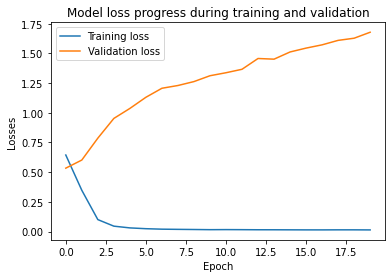

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.legend(['Training loss', 'Validation loss'])

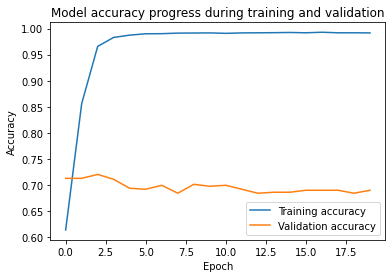

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training accuracy', 'Validation accuracy'])

## Previsões

In [ ]:
text = 'i hate you'
text = tokenizer.encode(text)
text

[170, 2632, 4939]

In [ ]:
Dcnn(np.array([text]), training=False).numpy()

array([[0.9303558]], dtype=float32)

#Explicação Final

- Após executar um treinamento de 20 epochs foi observador uma accuracy de 69% de eficiencia ao ***aplicar redes neurais Convolucionais*** a base de dados do twitter em português.